# Procedimiento para determinar la posición de la imagen generada por el modulador, después del sistema 4f

- **Autores**: Joaquín Andrés y Luis Miguel Sánchez Brea
- **Fecha**: 21 de mayo de 2021
- **Resumen**: Se desarrolla un procedimiento *automático* para obtener la distancia z0 donde se forma la imagen del modulador, después de pasar por el sistema 4f. El procedimiento es muy preciso. Se basa en medir la desviación estándar y obtener el valor ¿mínimo?. Esto se realiza varias veces, con $\Delta$z cada vez menor
- **Observaciones**:
    - Colocar el sistema en la misma configuración de cómo se va a utilizar. Si tiene polarizadores, ponerlos

## Cargar Módulos

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import time
import datetime

In [3]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

number of processors: 4
total memory        : 6.0 Gb
available memory    : 53 %
max frequency       : 2794 GHz


In [4]:
from py_lab.camera import Camera
from py_lab.motor_linear import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports

In [6]:
from matplotlib import rcParams
rcParams['figure.figsize']=(14,6)
rcParams['figure.dpi']=300
rcParams['image.cmap']='afmhot'

%matplotlib inline

In [7]:
# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1

## Çargar dispositivos: cámara, motores y SLM

Encendemos la cámara, el motor y el modulador y los activamos para que sea Python el que los controle. 
Comenzamos con la cámara, y tomamos una imagen para comprobar que funciona. 

In [8]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain", 2)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 


0 : b'DMx 72BUC02 14210296'



-10



In [9]:
slm = SLM(name="HoloEye2500", M=0.7949)

In [10]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.grating_2D_chess(period=1000 * um, amin=0, amax=1., phase=0, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)
slm.Send_Image(mask, norm=1, kind='intensity')


(-0.5, 1023.5, -0.5, 767.5)

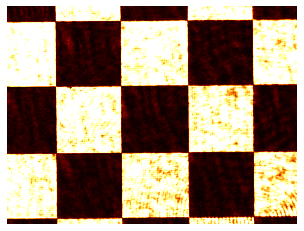

In [16]:
# Comprobamos que se obtiene una imagen. 
cam.Set_Property("Gain", 5)
cam.Set_Property("Exposure", -9)
time.sleep(0.5)

image = cam.Get_Image()

# Verificar
plt.figure()
plt.imshow(image, origin='lower')
plt.axis('off')


Ahora toca manejar el motor: 

In [17]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage SMC100 ready


Por último. queda el uso del modulador: 

In [18]:
devices = (slm, cam, motor)

## Experimento 1. Obtención de z=0. Calibración y alineado



Funciones para hacer un barrido y obtener la STD

In [19]:
def get_z0(devices, positions, grado, remove_background=True, has_draw=True, verbose=True):
    stdsol = np.zeros_like(positions)
    mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
    mask.grating_2D_chess(period=1000 * um, amin=0, amax=1., phase=0, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)
    mask_null = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
    mask_null.one_level(0)
    for i,z in enumerate(positions): 
        motor.Move_Absolute(pos=positions[i],units='mm', verbose=False, move_time=None)
        std_max=0
        if remove_background:
            slm.Send_Image(mask_null, norm=1, kind='intensity')
            time.sleep(0.2)
            imageb = cam.Get_Image()
            slm.Send_Image(mask, norm=1, kind='intensity')
            time.sleep(0.2)
            imagem = cam.Get_Image()
            image = imagem - imageb
            image[image < 0] = 0
        else:
            image = cam.Get_Image()
        std_new=np.std(image)
        if std_new > std_max:
            std_max=std_new
            image_best=image
        stdsol[i]=std_new
        print(z,end='\r')
    fajuste = np.polyfit(positions,stdsol,grado)
    y2 = np.poly1d(fajuste)
    x2 = np.linspace(positions[0],positions[-1],100)
    max_ajuste =x2[y2(x2).argmax()]
    max_array = positions[stdsol.argmax()]
    if has_draw is True:
        plt.figure()
        plt.imshow(image_best)
        
        stdfig = plt.figure()
        ax = stdfig.subplots()
        ax.plot(positions, stdsol, '.',label='Datos')
        ax.plot(x2,y2(x2),label='Ajuste, máximo = {:.3f} mm'.format(max_ajuste))
        plt.xlabel('Posición de la cámara (mm)')
        plt.ylabel('STD')
        plt.title('STD en función de z. Obtención de z=0')
        plt.legend()
        plt.show()
    if verbose is True:
        print(max_ajuste, max_array)
    return max_ajuste, max_array, std_max, image_best

In [20]:
def get_z0_best(devices,z_inicial,Deltas,num_data ,grados_polinomio):
    (slm, cam, motor) = devices
    std_absolute=0
    z_best=0
    image_final = cam.Get_Image()
    for i,Dz in enumerate(Deltas):
        positions = np.linspace(z_inicial-Dz/2,z_inicial+Dz/2, num_data[i])
        max_ajuste, max_array, std_max,  image_best = get_z0(devices, positions, grado=grados_polinomio[i], remove_background=True, has_draw=True, verbose=False)
        if std_max>std_absolute:
            std_absolute=std_max
            z_best=max_array
            image_final = image_best
        z_inicial=max_array
    z_final=z_best
    motor.Move_Absolute(pos=z_final,units='mm', verbose=False, move_time=None)
    
    return z_final, image_final



## Definición de los barrido

In [21]:
cam.Set_Property("Gain", 5)
cam.Set_Property("Exposure", -9)

In [22]:
# Posición inicial
z_inicial=110
Deltas=(10, 2.5, 0.5, 0.2)
grados_polinomio=[8,6,4,2]
num_data = (20, 15, 15, 15)
devices = (slm, cam, motor)

<ipython-input-20-996ec010fdfc>:8: RankWarning: Polyfit may be poorly conditioned
  max_ajuste, max_array, std_max,  image_best = get_z0(devices, positions, grado=grados_polinomio[i], remove_background=True, has_draw=True, verbose=False)


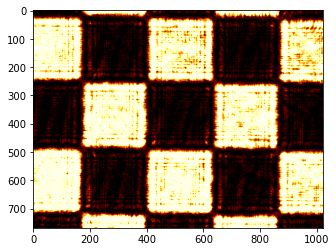

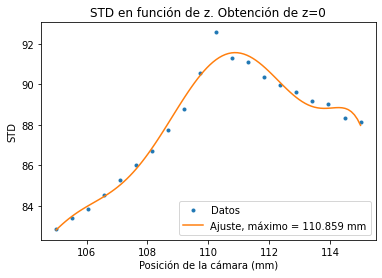

<ipython-input-20-996ec010fdfc>:8: RankWarning: Polyfit may be poorly conditioned
  max_ajuste, max_array, std_max,  image_best = get_z0(devices, positions, grado=grados_polinomio[i], remove_background=True, has_draw=True, verbose=False)


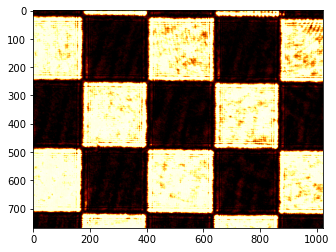

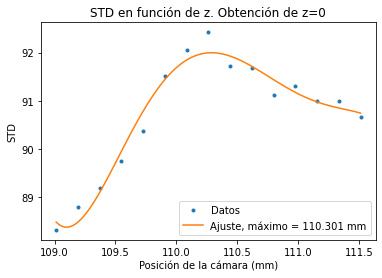

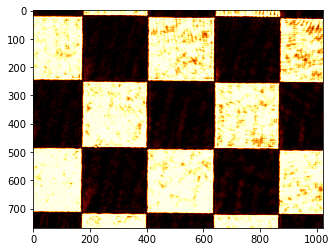

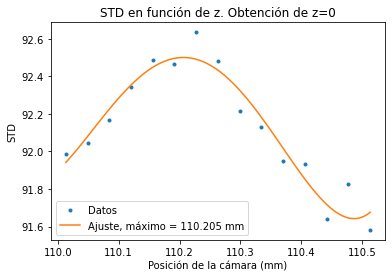

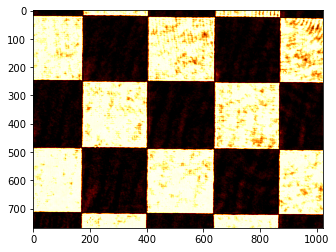

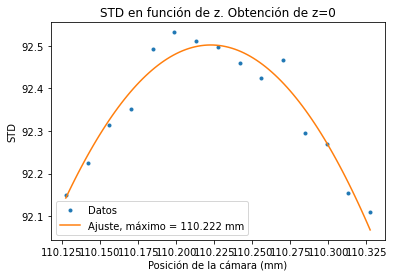

In [23]:
z_final, image_final = get_z0_best(devices,z_inicial,Deltas,num_data, grados_polinomio)

In [24]:
print('La posición de z = 0 en el motor es z = {:2.2f} mm'.format(z_final))

La posición de z = 0 en el motor es z = 110.20 mm


## Grabar la posición mejor

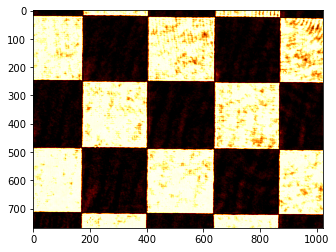

In [25]:
plt.imshow(image_final)

In [26]:
motor.Move_Absolute(pos=z_final,units='mm', verbose=False, move_time=None);

In [27]:
mask_null = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask_null.one_level(0)
slm.Send_Image(mask_null, norm=1, kind='intensity')
time.sleep(0.3)
image_background = cam.Get_Image(is_background=True)

In [28]:
# Comprobamos que se obtiene una imagen. 
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.grating_2D_chess(period=1000 * um, amin=0, amax=1., phase=0, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)

slm.Send_Image(mask, norm=1, kind='intensity')
time.sleep(0.3)
image = cam.Get_Image(rest_background=True)

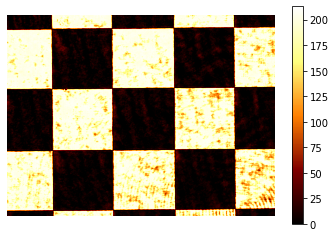

In [29]:
# Verificar
plt.figure()
plt.imshow(image, origin='lower')
plt.axis('off')
plt.colorbar()

In [56]:
now = datetime.datetime.now() 
d = now.strftime("%Y_%m_%d_%H_%M")
print(d)
np.savez('data/best_z0_{}___{:4.4f}.npz'.format(d,z_final),z_final)
np.savez('data/best_z0.npz',z_final)

2021_07_14_14_39


In [47]:
slm.Close_All_Images()
motor.Close()
cam.Stop_Live()

In [52]:
del motor
del cam
del slm